## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Computer camera calibration matrix

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. use the calibration for new image testing  

test on image file  ../camera_cal\calibration10.jpg


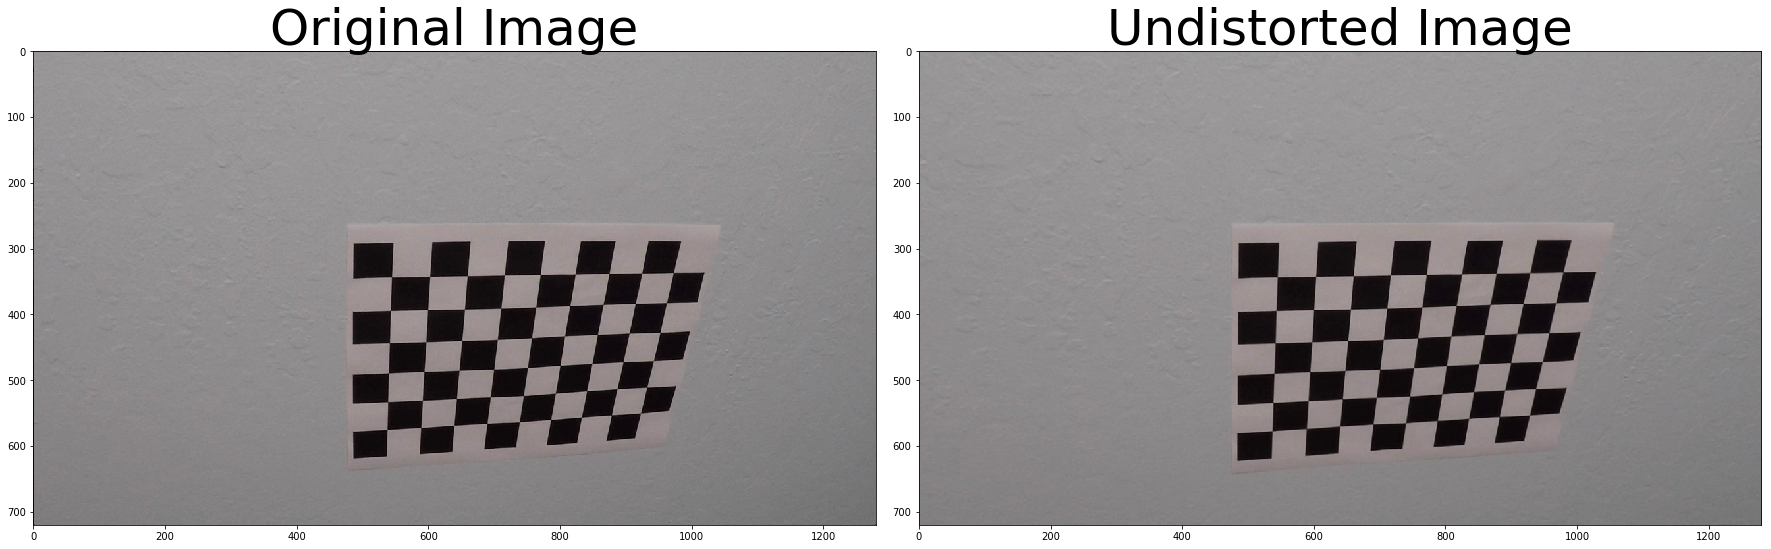

In [26]:
%matplotlib inline
import numpy as np

testidx = np.random.randint(0, len(images))
print('test on image file ', images[testidx])
img = cv2.imread(images[testidx])

dst = cv2.undistort(img, mtx, dist, None, mtx)
# plt.imshow(dst)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


..\test_images\straight_lines1.jpg


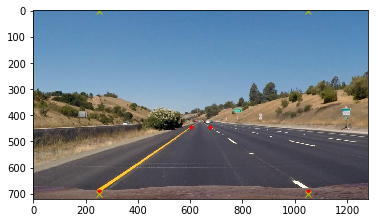

In [128]:
import os
%matplotlib inline
pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
print(pers_img)
img = cv2.imread(pers_img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
src = np.float32([[603, 444], [675, 444], [1050, 688], [253, 688]])
dst = np.float32([[250, 0], [1050, 0], [1050, 700], [250, 700]])
'''
      1   2
       ---
      /   \
     /     \
    /       \
    ---------
   4         3 
'''
plt.plot(*src[0], '.', color = 'r')
plt.plot(*src[1], '.', color = 'r')
plt.plot(*src[2], '.', color = 'r')
plt.plot(*src[3], '.', color = 'r')
plt.plot(*dst[0], 'x', color = 'y')
plt.plot(*dst[1], 'x', color = 'y')
plt.plot(*dst[2], 'x', color = 'y')
plt.plot(*dst[3], 'x', color = 'y')

# computer the perspective transformation matrix
M = cv2.getPerspectiveTransform(trap_points, warp_points)

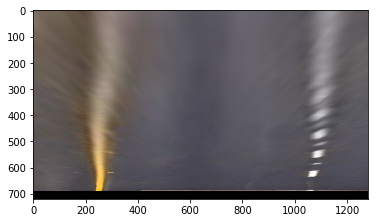

In [129]:
# do transformation on the test image
# check the final warped image after perspective transformation
img_size = img.shape[1], img.shape[0]
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [130]:
from cv2 import Sobel

def build_binary_img(img, rawtype = 'bgr', orient = 'x', sobeltype = 's', s_thresh = (170, 255), sobel_thresh = (20, 100)):
    if rawtype == 'rgb': # cv2.imread
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif rawtype == 'bgr': # matplotlib.image.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else:  # gray
        assert 0

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    channel = gray
    sobelx = Sobel(channel, cv2.CV_64F, 1, 0)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    
    sobely = Sobel(channel, cv2.CV_64F, 0, 1)
    sobely = np.absolute(sobely)
    sobely = np.uint8(255*sobely/np.max(sobely))

    # sobel_thresh = (20, 100)
    sobel_bin = np.zeros_like(sobelx)
    if orient == 'x':
        sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 1
    else:
        sobel_bin[(sobely >= sobel_thresh[0]) & (sobely <= sobel_thresh[1])] = 1
        
    channel = S
    color_bin = np.zeros_like(channel)
    if orient == 'x':
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    else:
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1

    combined_bin = np.zeros_like(gray)
    combined_bin[(color_bin == 1) | (sobel_bin == 1)] = 1

#     sobel_bin = np.dstack(sobel_bin*3) *255
#     color_bin = np.dstack(color_bin*3) *255
#     combined_bin = np.dstack(combined_bin*3) *255
    
    return sobel_bin*255, color_bin*255, combined_bin*255

testing the binary img build function on test image  ../test_images\straight_lines2.jpg


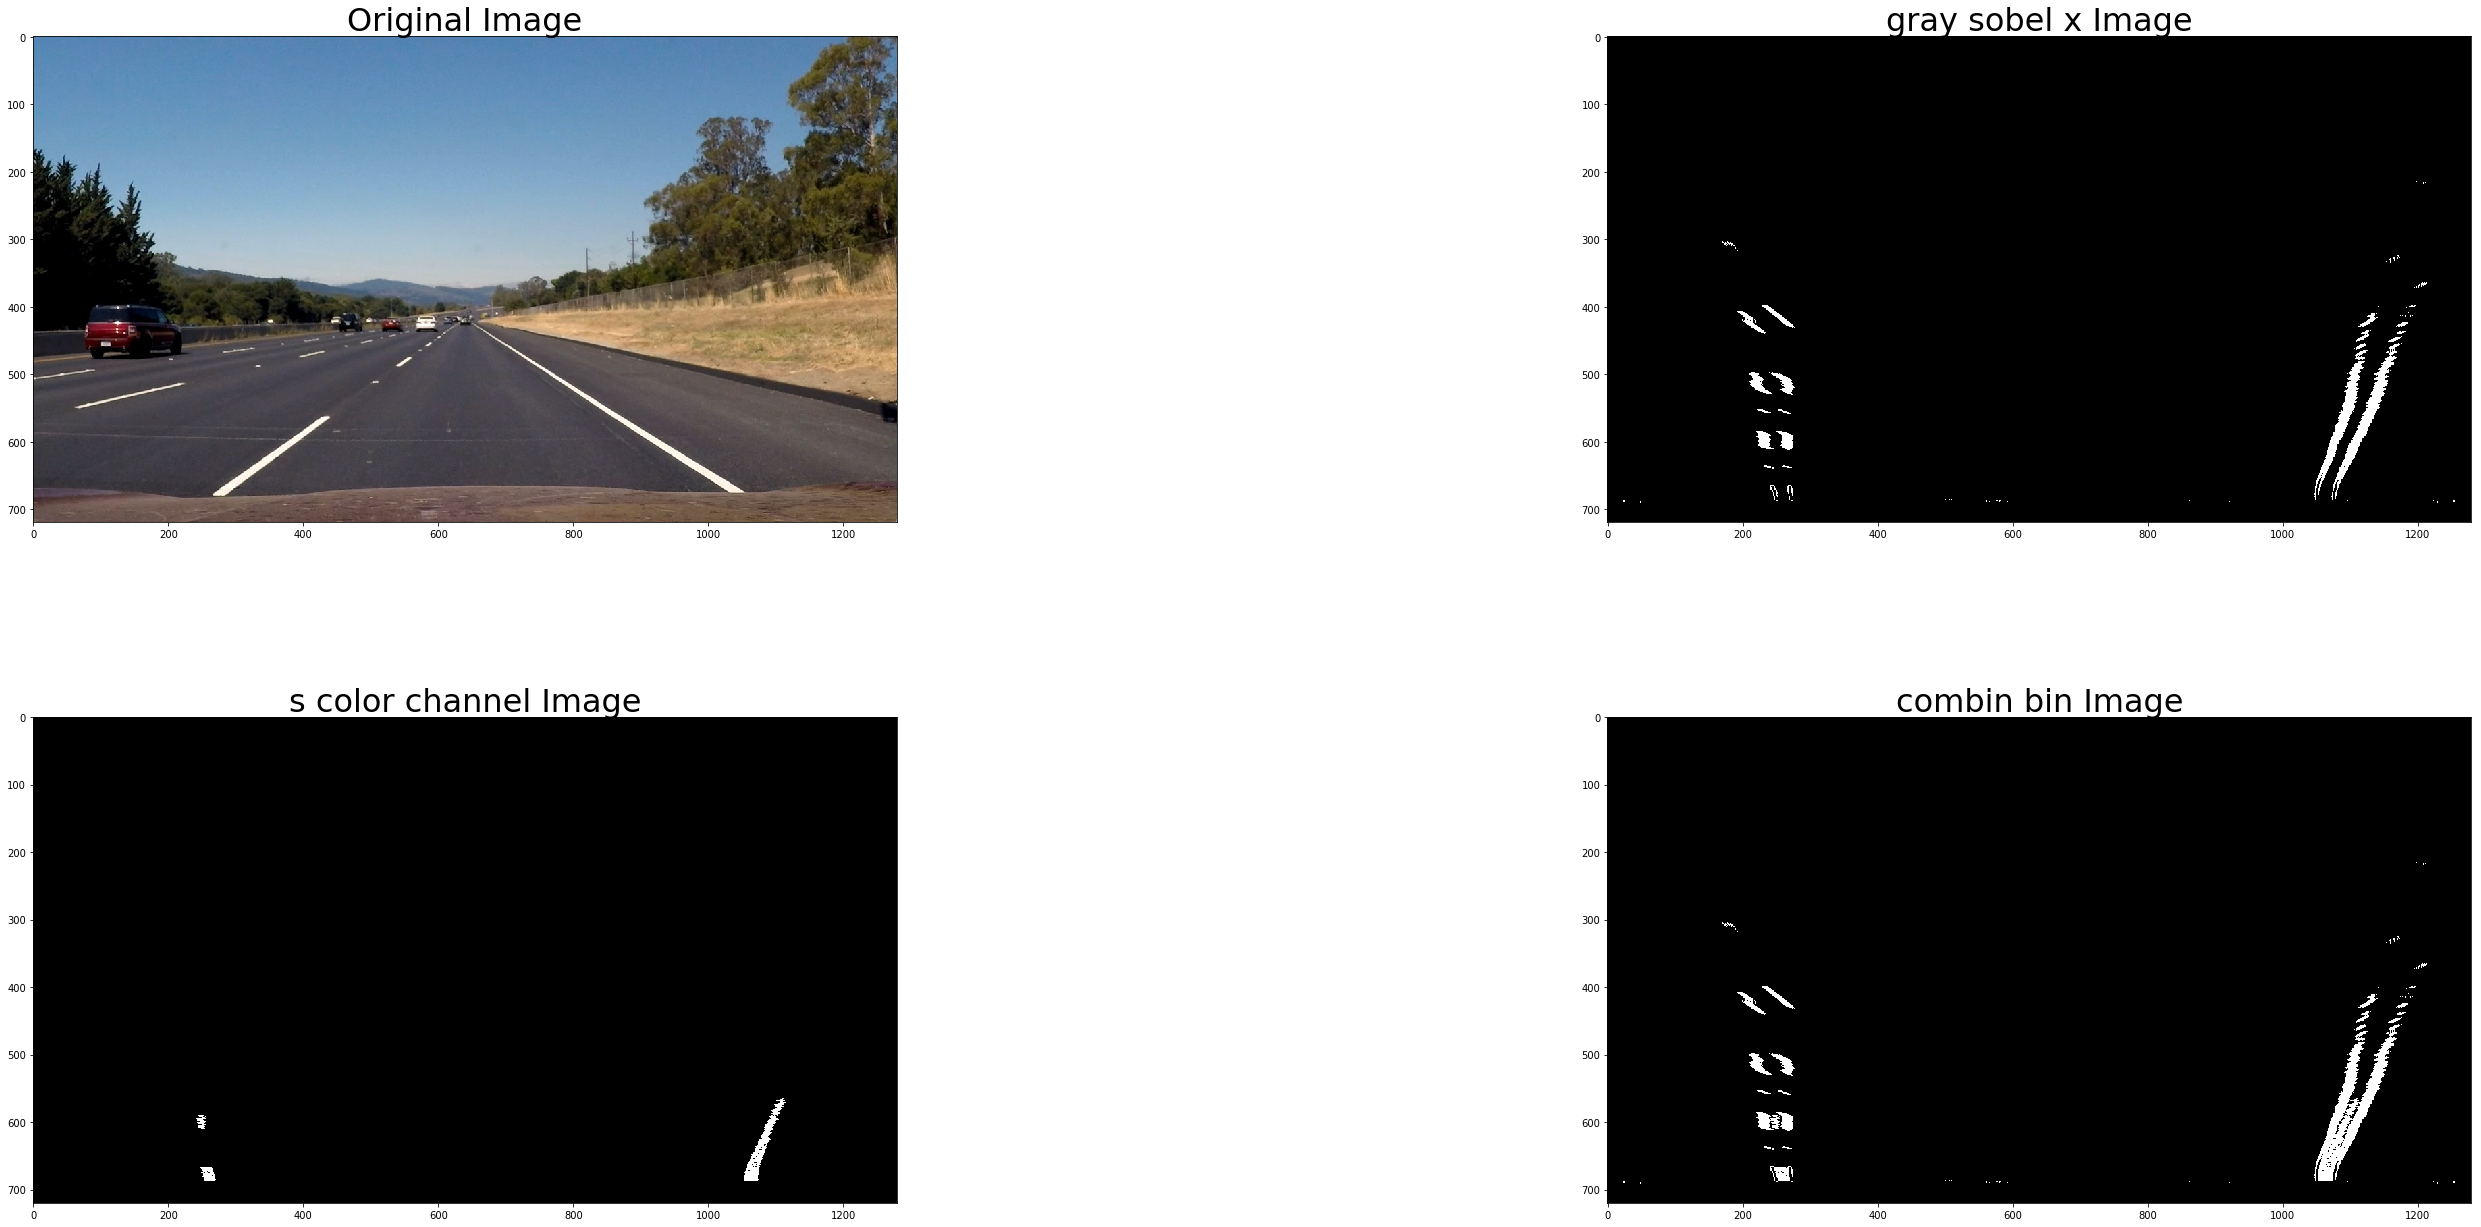

In [131]:
# test the function build_binary_image()
images = glob.glob('../test_images/*.jpg')
testidx = np.random.randint(0, len(images))
print('testing the binary img build function on test image ', images[testidx])

img = cv2.imread(images[testidx])
img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )

f, ax = plt.subplots(2, 2, figsize=(48, 18))
f.tight_layout()
ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0][0].set_title('Original Image', fontsize=32)

ax[0][1].imshow(img1, cmap = 'gray')
ax[0][1].set_title('gray sobel x Image', fontsize=32)

ax[1][0].imshow(img2, cmap = 'gray')
ax[1][0].set_title('s color channel Image', fontsize=32)

ax[1][1].imshow(img3, cmap = 'gray')
ax[1][1].set_title('combin bin Image', fontsize=32)

plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)



### 5. Detect lane pixels and fit to find the lane boundary.

(720, 1280)


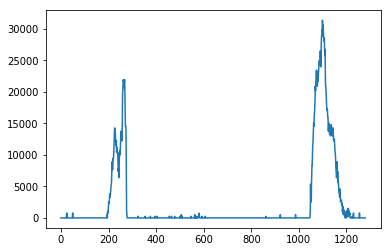

In [132]:
img = img3
print(img.shape)
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)


Sliding Window

### 6. Determine the curvature of the lane and vehicle position with respect to center.

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function